Hello and welcome to my notebook for the Kaggle "Titanic: Machine Learning from Disaster" Competition. It is a supervised binary classification problem, with the goal of predicting whether a passenger survived the Titanic sinking or not, based on the dataset given on the competition page. The competition's page with more explanation and the dataset can be found on the next link:

https://www.kaggle.com/c/titanic

This is the first Kaggle competition that I am competing in, and as such presents a way for me to get familiar with some basic concepts of Machine Learning.

It will be divided into 2 parts, from which the first one will consist of data preprocessing and in the second part I will be dealing with some of the most common ML algorithms, while following closely the book "Hands-on Machine learning with SciKit-Learn and Tensorflow" as a guide. Also, I have used some of the kernels on the competition page for ideas on the data preprocessing steps, but none of the code was taken from there.
    
To start off, we load the training and the test set, have a first look at the data, and start the steps of the data preprocessing. Since I will be using a number of models, out of which some of them only work with numeric data and are not capable of handling missing data, I will handle the missing data and then transform all the data into numeric values. The steps that will be taken in the data preprocessing are in the next order:

1) Handling the missing data;

2) Extracting new features, and getting rid of the redundant ones;

3) Getting rid of the outliers and checking the normality of the most important continous numeric features;  

4) Making sure that all the data is numeric and saving the data for later use.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

from IPython.display import clear_output

DATA_PATH = "data/"
TRAIN_DATA_NAME = "train.csv"
TEST_DATA_NAME = "test.csv"

def load_titanic_data(trainset = True):
    data_path = DATA_PATH
    if trainset:
        data_name = TRAIN_DATA_NAME
    else:
        data_name = TEST_DATA_NAME
    csv_path = os.path.join(data_path, data_name)
    return pd.read_csv(csv_path)

train_data = load_titanic_data()
test_data = load_titanic_data(trainset = False)

train_data_cc = train_data.copy()
test_data_cc = test_data.copy()

label = "Survived"
test_data_id = test_data_cc["PassengerId"].copy()

print(train_data_cc.info())
print(test_data_cc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null 

In [2]:
print("Train data set described:")
print(train_data_cc.describe())
print("\n\n\n")
print("Test data set described:")
print(test_data_cc.describe())

Train data set described:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  




Test data set described:
       PassengerId      Pc

As can be observed, categories Age, Cabin, Embarked, and Fare have missing values.

Embarked and Fare have only a couple of missing values, so we can fill them with the most frequent value and the median, respectively (Most frequent for Embarked, as it is a textual categorical feature, and median for Fare, as it is a continous numerical value).

In [3]:
test_data_cc["Fare"].fillna(test_data_cc["Fare"].median(), inplace = True)
train_data_cc["Embarked"].fillna(train_data_cc["Embarked"].value_counts().index[0], inplace = True)

Age category has too many missing values, so filling it with the median would not be satisfiable. Instead, I can assume that the fact that there is missing data for that feature is of importance, and that passengers whose age is unknown were maybe more likely not to survive. Therefore, I will fill the missing data with a value that indicates special case (ex. -1), and categorise the age data into several categories, based on the age range span, where age = -1 would be treated as a special case of missing the age information. Age categories would be made in such way to check the assumption that the age of the passengers is correlated to the label ("Survived" category), and that it is, as such, an important feature.

The new category's important information would then be plotted, and the old Age category would then be dropped.

In [5]:
train_data_cc["Age"].fillna(-1.0, inplace = True)
test_data_cc["Age"].fillna(-1.0, inplace = True)

Adult             196
Older_Adult       195
Missing           177
Young_Adult       162
Teenager           56
Child              34
Baby               30
Senior             22
Young_Teenager     19
Name: Age_categories, dtype: int64
Older_Adult       94
Young_Adult       88
Missing           86
Adult             85
Teenager          22
Senior            11
Child             11
Baby              11
Young_Teenager    10
Name: Age_categories, dtype: int64


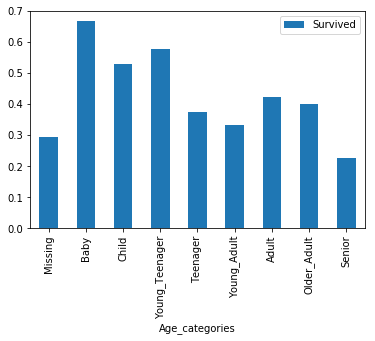

In [6]:
cuts = [-2,0,3,10,15,18,25,35,60,90]
new_labels = ["Missing","Baby","Child","Young_Teenager","Teenager","Young_Adult","Adult","Older_Adult","Senior"]

train_data_cc["Age_categories"] = pd.cut(train_data_cc["Age"],cuts,labels=new_labels)
test_data_cc["Age_categories"] = pd.cut(test_data_cc["Age"],cuts,labels=new_labels)

print(train_data_cc["Age_categories"].value_counts())
print(test_data_cc["Age_categories"].value_counts())

pivot = train_data_cc.pivot_table(index=["Age_categories"],values=label)
pivot.plot.bar()
plt.show()

In [7]:
train_data_cc.drop(["Age"], axis=1, inplace=True)
test_data_cc.drop(["Age"], axis=1, inplace=True)

The last feature (would also be referenced as a "column" in the notebook, interchangeably) with missing values is the Cabin column. Due to the amount of missing data (more than 70% in both the training and the test set), the feature could be dropped, but instead I have decided to treat it similar to the Age category. I assume that the fact that a passenger's Cabin is unknown has some information of meaning, so those instances will be filled with "None". When it comes to the known Cabin values, they consist of a letter and a number. The letter corresponds to the Deck, and the number is the location of the Cabin on the deck. I extracted only the Deck letter, as I assume that the higher decks had higher survival rates. Those instances with the deck value of None will be given the Deck_N value.  

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64
N    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64


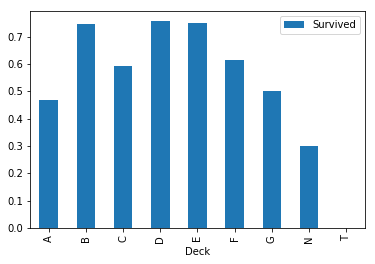

In [8]:
train_data_cc["Cabin"].fillna("None", inplace = True)
test_data_cc["Cabin"].fillna("None", inplace = True)

train_data_cc["Deck"] = train_data_cc["Cabin"].str.slice(0,1)
test_data_cc["Deck"] = test_data_cc["Cabin"].str.slice(0,1)
print(train_data_cc["Deck"].value_counts())
print(test_data_cc["Deck"].value_counts())
pivot = train_data_cc.pivot_table(index=["Deck"],values=label)
pivot.plot.bar()
plt.show()

Since Deck T only exists in the training set, it is redundant, and since Deck G only has 1 instance in the test set, I am considering it redundant too. That means that the next step is to call the get_dummies() method for the Deck feature, turning it into numeric features for each of the values, and after that drop the Deck_T and Deck_G features

In [9]:
train_data_cc = pd.get_dummies(train_data_cc, prefix=["Deck"], columns=["Deck"])
test_data_cc = pd.get_dummies(test_data_cc, prefix=["Deck"], columns=["Deck"])

train_data_cc.drop(["Cabin", "Deck_T", "Deck_G"], axis=1, inplace=True) # Doesnt have the T deck
test_data_cc.drop(["Cabin", "Deck_G"], axis=1, inplace=True)

In [10]:
print(train_data_cc.info())
print(test_data_cc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId       891 non-null int64
Survived          891 non-null int64
Pclass            891 non-null int64
Name              891 non-null object
Sex               891 non-null object
SibSp             891 non-null int64
Parch             891 non-null int64
Ticket            891 non-null object
Fare              891 non-null float64
Embarked          891 non-null object
Age_categories    891 non-null category
Deck_A            891 non-null uint8
Deck_B            891 non-null uint8
Deck_C            891 non-null uint8
Deck_D            891 non-null uint8
Deck_E            891 non-null uint8
Deck_F            891 non-null uint8
Deck_N            891 non-null uint8
dtypes: category(1), float64(1), int64(5), object(4), uint8(7)
memory usage: 77.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId       418 no

Now that there is no missing data, I will do the next steps:

1) Immediately drop the features that are redundant and that cannot give any information of use (PassengerId, Ticket);

2) Extract the new features from the already existing ones;

3) Transform the ramining text categorical features into their numeric representations.

In [11]:
test_data_id = test_data_cc["PassengerId"].copy() # Will be used later for submissions

train_data_cc.drop(["PassengerId"], axis = 1, inplace = True)
test_data_cc.drop(["PassengerId"], axis = 1, inplace = True)
train_data_cc.drop(["Ticket"], axis=1, inplace=True)
test_data_cc.drop(["Ticket"], axis=1, inplace=True)

The first feature that can be extracted is the Title of the person, as it can be observed that all the names have a title. No other information, like Family Name or the First Name, can be transformed into useful information, so after the extracted and simplified Title feature, the Name will be dropped.

In [12]:
train_data_cc["Title"] = train_data_cc["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data_cc["Title"] = test_data_cc["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
print(train_data_cc["Title"].value_counts())
print(test_data_cc["Title"].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Countess      1
Jonkheer      1
Don           1
Capt          1
Ms            1
Mme           1
Lady          1
Sir           1
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64


Mr          517
Miss        185
Mrs         128
Master       40
Others       16
Military      5
Name: Title, dtype: int64
Mr          240
Miss         79
Mrs          73
Master       21
Others        3
Military      2
Name: Title, dtype: int64


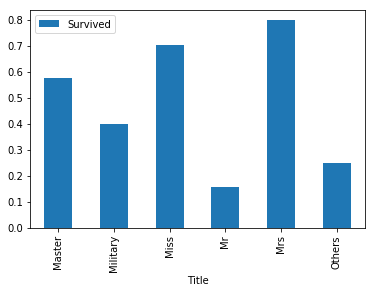

In [13]:
train_data_cc["Title"] = train_data_cc["Title"].replace(["Capt", "Col","Major"], "Military")
train_data_cc["Title"] = train_data_cc["Title"].replace(["Don", "Dr", "Rev", "Sir", "Jonkheer"], "Others")
train_data_cc["Title"] = train_data_cc["Title"].replace(["Mlle", "Ms"], "Miss")
train_data_cc["Title"] = train_data_cc["Title"].replace(["Mme","Lady", "Countess","Dona"], "Mrs")

test_data_cc["Title"] = test_data_cc["Title"].replace(["Capt", "Col","Major"], "Military")
test_data_cc["Title"] = test_data_cc["Title"].replace(["Don", "Dr", "Rev", "Sir", "Jonkheer"], "Others")
test_data_cc["Title"] = test_data_cc["Title"].replace(["Mlle", "Ms"], "Miss")
test_data_cc["Title"] = test_data_cc["Title"].replace(["Mme","Lady", "Countess","Dona"], "Mrs")

print(train_data_cc["Title"].value_counts())
print(test_data_cc["Title"].value_counts())
pivot = train_data_cc.pivot_table(index=["Title"],values=label)
pivot.plot.bar()
plt.show()

In [14]:
train_data_cc.drop(["Name"], axis = 1, inplace = True)
test_data_cc.drop(["Name"], axis = 1, inplace = True)

Next feature that could be extracted is the total number of Family members. I have also observed that the ticket price (Fare), is the same for all the people sharing the same family name (probably the ticket was bought for all of them together, as they are sharing the Cabin). Therefore, it makes sense to make a feature of FarePerPerson (Fare / FamilyMembers), that would, to my assumption, correlate even better to how expensive the ticket really was.

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilyMembers, dtype: int64
0     253
1      74
2      57
3      14
4       7
10      4
6       4
5       3
7       2
Name: FamilyMembers, dtype: int64


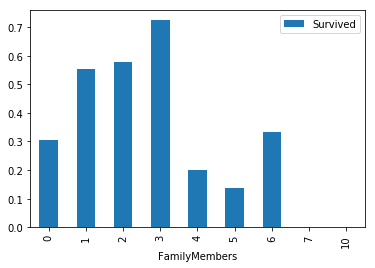

In [15]:
train_data_cc["FamilyMembers"] = train_data_cc["SibSp"]+train_data_cc["Parch"]
test_data_cc["FamilyMembers"] = test_data_cc["SibSp"]+test_data_cc["Parch"]

train_data_cc["FarePerPerson"] = train_data_cc["Fare"]/(train_data_cc["FamilyMembers"]+1)
test_data_cc["FarePerPerson"] = test_data_cc["Fare"]/(test_data_cc["FamilyMembers"]+1)

print(train_data_cc["FamilyMembers"].value_counts())
print(test_data_cc["FamilyMembers"].value_counts())
pivot = train_data_cc.pivot_table(index=["FamilyMembers"],values=label)
pivot.plot.bar()
plt.show()

Once that was made, I would transform the FamilyMembers feature into a feature that I assume is more interesting, FamilyType. Based on the number of Family Members of each passenger, I would group them into belonging to one of 4 categories: Solo passengers, SmallFamily members, MediumFamily members, and BigFamily members. The assumption is that Families of 2-4 members are most likely to have their members survive. 
Solo passengers are most probably adults with no children and are probably less likely to survive. 
Members of big families (5+ members) are also less likely to survive, due to small the chances of all of them being admitted on the lifeboats.

No        537
Small     161
Medium    131
Big        62
Name: FamilyType, dtype: int64
No        253
Small      74
Medium     71
Big        20
Name: FamilyType, dtype: int64


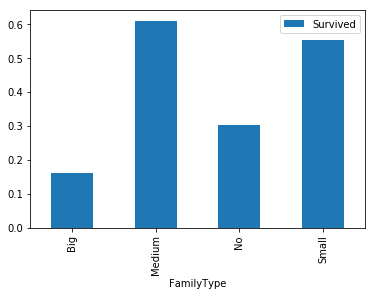

In [16]:
train_data_cc.loc[(train_data_cc["FamilyMembers"].isin([0])), "FamilyType"] = "No"
train_data_cc.loc[(train_data_cc["FamilyMembers"].isin([1])), "FamilyType"] = "Small"
train_data_cc.loc[(train_data_cc["FamilyMembers"].isin([2,3])), "FamilyType"] = "Medium"
train_data_cc.loc[(train_data_cc["FamilyMembers"].isin([4,5,6,7,10])), "FamilyType"] = "Big"

test_data_cc.loc[(test_data_cc["FamilyMembers"].isin([0])), "FamilyType"] = "No"
test_data_cc.loc[(test_data_cc["FamilyMembers"].isin([1])), "FamilyType"] = "Small"
test_data_cc.loc[(test_data_cc["FamilyMembers"].isin([2,3])), "FamilyType"] = "Medium"
test_data_cc.loc[(test_data_cc["FamilyMembers"].isin([4,5,6,7,10])), "FamilyType"] = "Big"

print(train_data_cc["FamilyType"].value_counts())
print(test_data_cc["FamilyType"].value_counts())
pivot = train_data_cc.pivot_table(index=["FamilyType"],values=label)
pivot.plot.bar()
plt.show()

train_data_cc.drop(["FamilyMembers"], axis = 1, inplace = True)
test_data_cc.drop(["FamilyMembers"], axis = 1, inplace = True)

In [17]:
print(train_data_cc.info())
print(test_data_cc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Sex               891 non-null object
SibSp             891 non-null int64
Parch             891 non-null int64
Fare              891 non-null float64
Embarked          891 non-null object
Age_categories    891 non-null category
Deck_A            891 non-null uint8
Deck_B            891 non-null uint8
Deck_C            891 non-null uint8
Deck_D            891 non-null uint8
Deck_E            891 non-null uint8
Deck_F            891 non-null uint8
Deck_N            891 non-null uint8
Title             891 non-null object
FarePerPerson     891 non-null float64
FamilyType        891 non-null object
dtypes: category(1), float64(2), int64(4), object(4), uint8(7)
memory usage: 77.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
Pclass            418 

Now that all the interesting features have been extracted, the redundant ones have been deleted and there is no more missing data, I will transform the categorical text features into numeric by calling the get_dummies() function.

In [18]:
text_features = ["FamilyType","Title","Age_categories","Embarked","Sex"]

train_data_cc = pd.get_dummies(train_data_cc, prefix=text_features, columns=text_features)
test_data_cc = pd.get_dummies(test_data_cc, prefix=text_features, columns=text_features)

Sex_male and Sex_female features now hold the same piece of information, so one of them should be dropped (ex. Sex_male)

In [19]:
train_data_cc.drop(["Sex_male"], axis = 1, inplace = True)
test_data_cc.drop(["Sex_male"], axis = 1, inplace = True)

print(train_data_cc.info())
print(test_data_cc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 36 columns):
Survived                         891 non-null int64
Pclass                           891 non-null int64
SibSp                            891 non-null int64
Parch                            891 non-null int64
Fare                             891 non-null float64
Deck_A                           891 non-null uint8
Deck_B                           891 non-null uint8
Deck_C                           891 non-null uint8
Deck_D                           891 non-null uint8
Deck_E                           891 non-null uint8
Deck_F                           891 non-null uint8
Deck_N                           891 non-null uint8
FarePerPerson                    891 non-null float64
FamilyType_Big                   891 non-null uint8
FamilyType_Medium                891 non-null uint8
FamilyType_No                    891 non-null uint8
FamilyType_Small                 891 non-null uint8
Title_M

Now that all the data is numeric I will plot Fare and FarePerPerson as continous numeric data, and all the other features as categorical (discrete) numeric data, to gain more insight into the current version of the training set. 

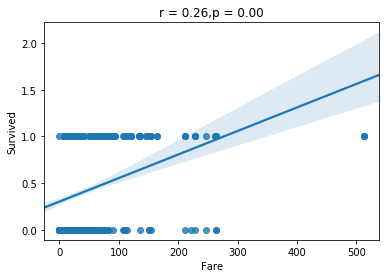

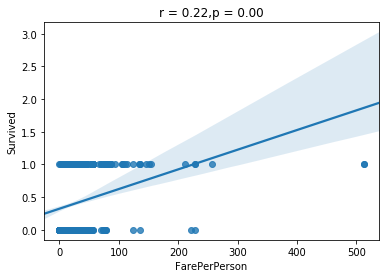

In [20]:
from scipy import stats

continous = ["Fare", "FarePerPerson"]
all_features = list(test_data_cc.columns)
discrete = [item for item in all_features if item not in continous]

for category in continous:
    sns.regplot(train_data_cc[category], train_data_cc[label])
    stp = stats.pearsonr(train_data_cc[category], train_data_cc[label])
    str_title = "r = " + "{0:.2f}".format(stp[0]) + "," "p = " + "{0:.2f}".format(stp[1])
    plt.title(str_title)
    plt.show()

Outliers are those passengers that had expensive 1-class tickets, but that still didnt survive:

In [21]:
print(train_data_cc.loc[(train_data_cc['FarePerPerson'] >= 100) & (train_data_cc['Survived'] == 0)])

     Survived  Pclass  SibSp  Parch      Fare  Deck_A  Deck_B  Deck_C  Deck_D  \
118         0       1      0      1  247.5208       0       1       0       0   
373         0       1      0      0  135.6333       0       0       0       0   
527         0       1      0      0  221.7792       0       0       1       0   
557         0       1      0      0  227.5250       0       0       0       0   

     Deck_E     ...      Age_categories_Young_Teenager  \
118       0     ...                                  0   
373       0     ...                                  0   
527       0     ...                                  0   
557       0     ...                                  0   

     Age_categories_Teenager  Age_categories_Young_Adult  \
118                        0                           1   
373                        0                           1   
527                        0                           0   
557                        0                           0   

  

In [22]:
train_data_cc.drop(train_data_cc.index[[118, 373, 527, 557]], inplace = True)

Plot the distribution of these two features to check their normality

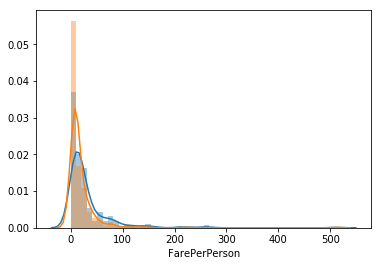

In [23]:
sns.distplot(train_data_cc["Fare"])
sns.distplot(train_data_cc["FarePerPerson"])

In [24]:
# As they have the 0 values, i need to use log1p

train_data_cc["Fare"] = np.log1p(train_data_cc["Fare"])
train_data_cc["FarePerPerson"] = np.log1p(train_data_cc["FarePerPerson"])

test_data_cc["Fare"] = np.log1p(test_data_cc["Fare"])
test_data_cc["FarePerPerson"] = np.log1p(test_data_cc["FarePerPerson"])

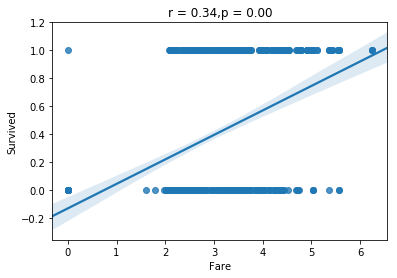

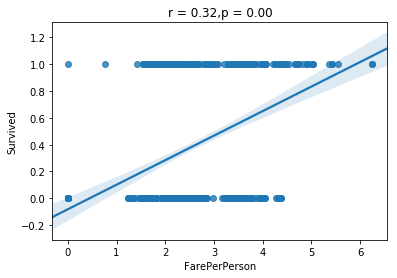

In [25]:
for category in continous:
    sns.regplot(train_data_cc[category], train_data_cc[label])
    stp = stats.pearsonr(train_data_cc[category], train_data_cc[label])
    str_title = "r = " + "{0:.2f}".format(stp[0]) + "," "p = " + "{0:.2f}".format(stp[1])
    plt.title(str_title)
    plt.show()

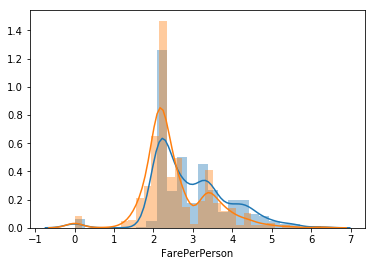

In [26]:
sns.distplot(train_data_cc["Fare"])
sns.distplot(train_data_cc["FarePerPerson"])

Looks much better, now I plot the discrete numeric features

3    491
1    212
2    184
Name: Pclass, dtype: int64
3    218
1    107
2     93
Name: Pclass, dtype: int64


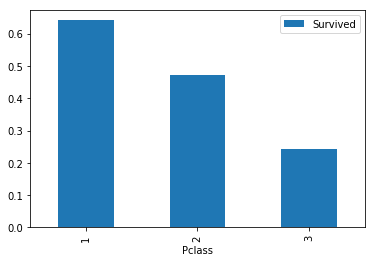

0    604
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    283
1    110
2     14
4      4
3      4
8      2
5      1
Name: SibSp, dtype: int64


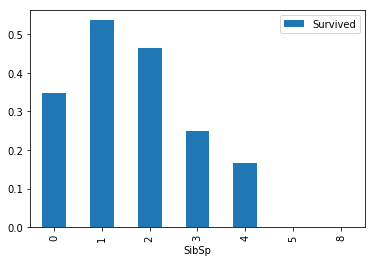

0    675
1    117
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
0    324
1     52
2     33
3      3
9      2
4      2
6      1
5      1
Name: Parch, dtype: int64


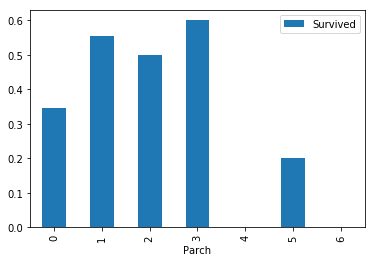

0    872
1     15
Name: Deck_A, dtype: int64
0    411
1      7
Name: Deck_A, dtype: int64


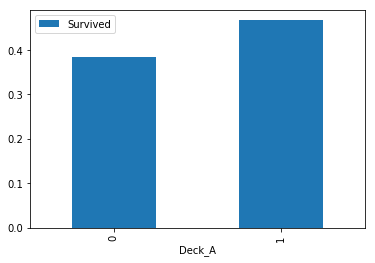

0    841
1     46
Name: Deck_B, dtype: int64
0    400
1     18
Name: Deck_B, dtype: int64


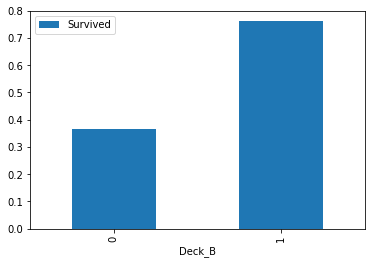

0    829
1     58
Name: Deck_C, dtype: int64
0    383
1     35
Name: Deck_C, dtype: int64


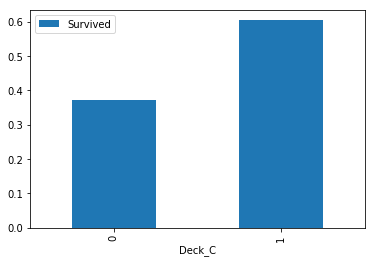

0    854
1     33
Name: Deck_D, dtype: int64
0    405
1     13
Name: Deck_D, dtype: int64


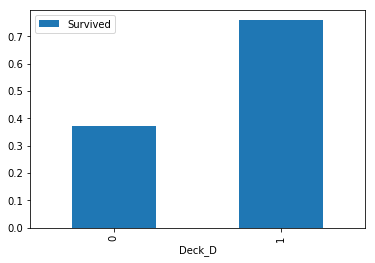

0    855
1     32
Name: Deck_E, dtype: int64
0    409
1      9
Name: Deck_E, dtype: int64


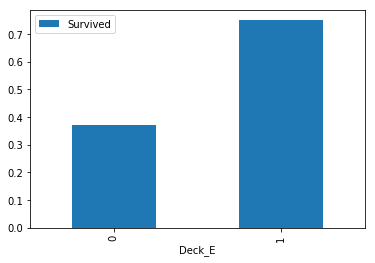

0    874
1     13
Name: Deck_F, dtype: int64
0    410
1      8
Name: Deck_F, dtype: int64


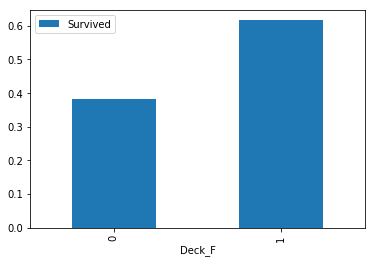

1    685
0    202
Name: Deck_N, dtype: int64
1    327
0     91
Name: Deck_N, dtype: int64


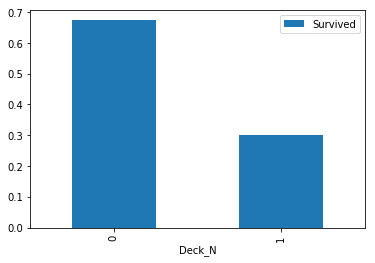

0    825
1     62
Name: FamilyType_Big, dtype: int64
0    398
1     20
Name: FamilyType_Big, dtype: int64


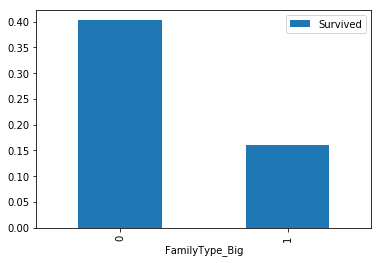

0    756
1    131
Name: FamilyType_Medium, dtype: int64
0    347
1     71
Name: FamilyType_Medium, dtype: int64


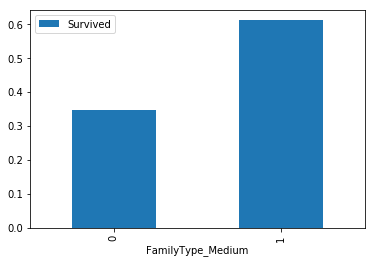

1    534
0    353
Name: FamilyType_No, dtype: int64
1    253
0    165
Name: FamilyType_No, dtype: int64


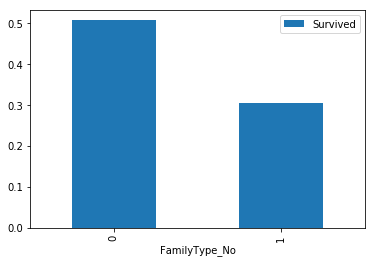

0    727
1    160
Name: FamilyType_Small, dtype: int64
0    344
1     74
Name: FamilyType_Small, dtype: int64


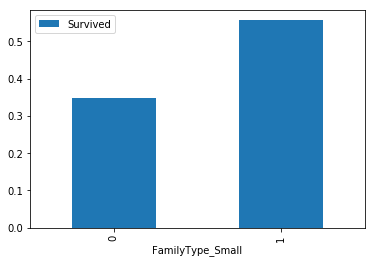

0    847
1     40
Name: Title_Master, dtype: int64
0    397
1     21
Name: Title_Master, dtype: int64


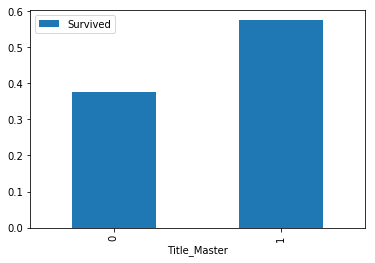

0    882
1      5
Name: Title_Military, dtype: int64
0    416
1      2
Name: Title_Military, dtype: int64


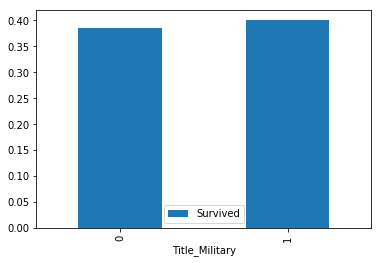

0    702
1    185
Name: Title_Miss, dtype: int64
0    339
1     79
Name: Title_Miss, dtype: int64


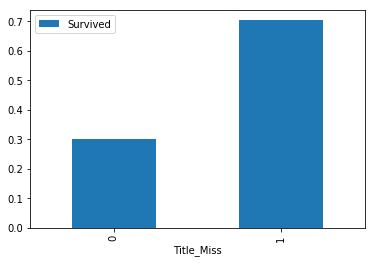

1    513
0    374
Name: Title_Mr, dtype: int64
1    240
0    178
Name: Title_Mr, dtype: int64


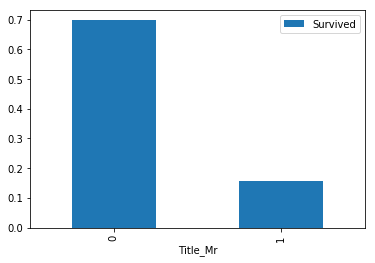

0    759
1    128
Name: Title_Mrs, dtype: int64
0    345
1     73
Name: Title_Mrs, dtype: int64


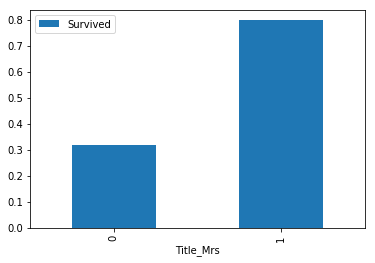

0    871
1     16
Name: Title_Others, dtype: int64
0    415
1      3
Name: Title_Others, dtype: int64


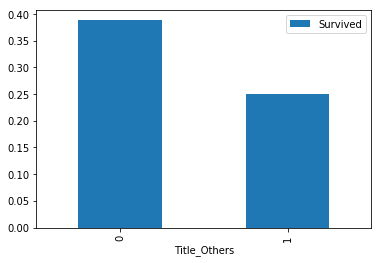

0    712
1    175
Name: Age_categories_Missing, dtype: int64
0    332
1     86
Name: Age_categories_Missing, dtype: int64


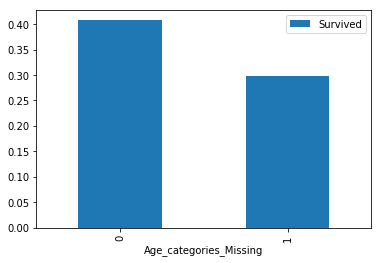

0    857
1     30
Name: Age_categories_Baby, dtype: int64
0    407
1     11
Name: Age_categories_Baby, dtype: int64


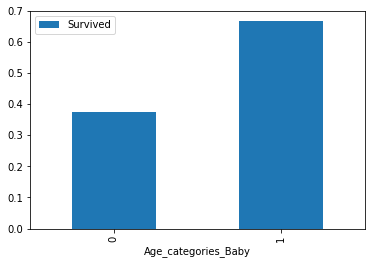

0    853
1     34
Name: Age_categories_Child, dtype: int64
0    407
1     11
Name: Age_categories_Child, dtype: int64


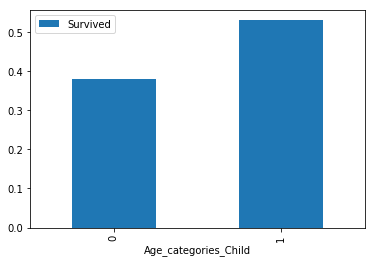

0    868
1     19
Name: Age_categories_Young_Teenager, dtype: int64
0    408
1     10
Name: Age_categories_Young_Teenager, dtype: int64


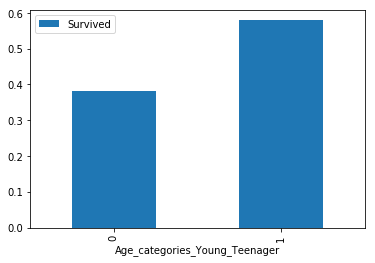

0    831
1     56
Name: Age_categories_Teenager, dtype: int64
0    396
1     22
Name: Age_categories_Teenager, dtype: int64


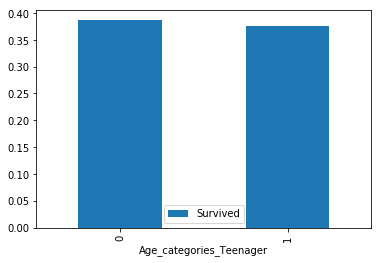

0    727
1    160
Name: Age_categories_Young_Adult, dtype: int64
0    330
1     88
Name: Age_categories_Young_Adult, dtype: int64


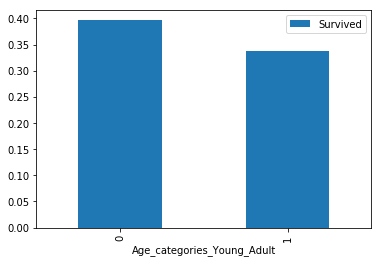

0    691
1    196
Name: Age_categories_Adult, dtype: int64
0    333
1     85
Name: Age_categories_Adult, dtype: int64


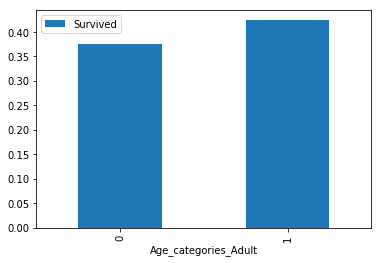

0    692
1    195
Name: Age_categories_Older_Adult, dtype: int64
0    324
1     94
Name: Age_categories_Older_Adult, dtype: int64


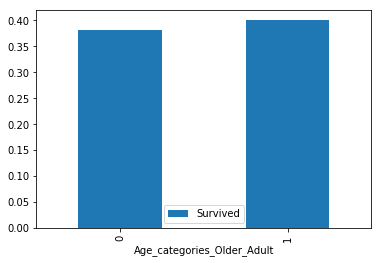

0    865
1     22
Name: Age_categories_Senior, dtype: int64
0    407
1     11
Name: Age_categories_Senior, dtype: int64


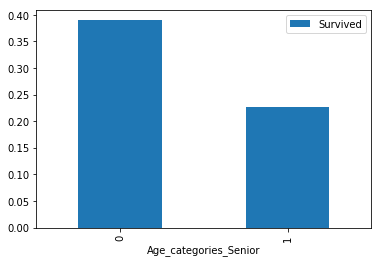

0    722
1    165
Name: Embarked_C, dtype: int64
0    316
1    102
Name: Embarked_C, dtype: int64


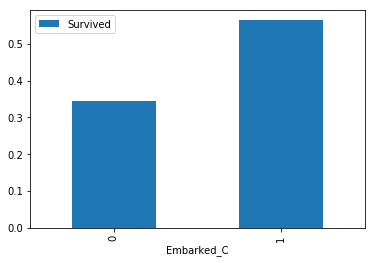

0    810
1     77
Name: Embarked_Q, dtype: int64
0    372
1     46
Name: Embarked_Q, dtype: int64


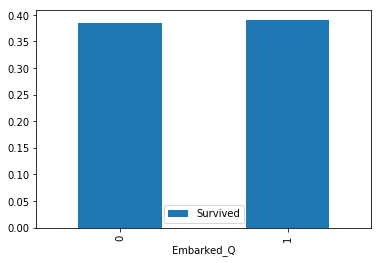

1    645
0    242
Name: Embarked_S, dtype: int64
1    270
0    148
Name: Embarked_S, dtype: int64


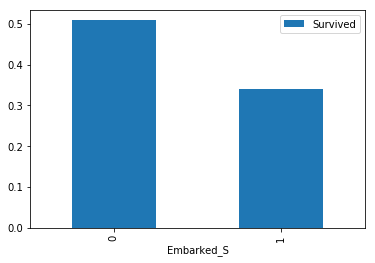

0    573
1    314
Name: Sex_female, dtype: int64
0    266
1    152
Name: Sex_female, dtype: int64


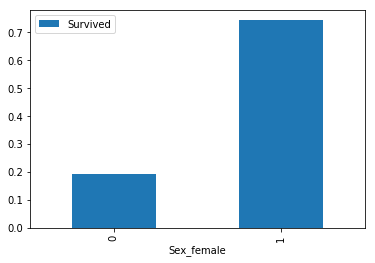

In [27]:
for category in discrete:
    print(train_data_cc[category].value_counts())
    print(test_data_cc[category].value_counts())
    pivot = train_data_cc.pivot_table(index=[category],values=label)
    pivot.plot.bar()
    plt.show()

Data preprocessing is here done, just need to save the data before I start preparing the data for training, and doing the actual training:

In [28]:
train_data_cc.to_csv("training_data.csv", index=False)
test_data_cc.to_csv("test_data.csv", index=False)
test_data_id.to_csv("test_ids.csv", index=False)

In [29]:
columns_all = list(test_data_cc.columns)

In [30]:
train_data = pd.read_csv("training_data.csv")
test_data = pd.read_csv("test_data.csv")
test_ids = pd.read_csv("test_ids.csv")

Before I start training the models, that are some decisions to be made:

1) Evaluation metrics - I decided to use cross validation on Stratified 10-Fold split. Another option was to split the data into the training and validation set, but I decided to go with the cross valdation on the whole training set, as the number of training instances is already pretty small.

2) Scalling - Even though some models that am using do not need the data to be scaled, some algorithms do, so I am also scaling the data using the standard scaler.

In [31]:
label = "Survived"
train_labels = train_data[label].copy()
train_data.drop([label], axis = 1, inplace = True)

In [32]:
from sklearn.model_selection import StratifiedKFold

split = StratifiedKFold(n_splits=10, random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

training_set = scaler.fit_transform(train_data)
test_set = scaler.fit_transform(test_data)

/home/goracinski/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/goracinski/.local/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/goracinski/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/goracinski/.local/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


I will now train models, following the course of the "Hands-on Machine learning with SciKit-Learn and Tensorflow" book. Models that will be used are:

1) Logistic Regression

2) SVM - Linear, RBF, Poly kernels

3) Decision Tree Clasifier

ensemble models:

4) Random Forest Classifier

5) Voting Classifier

6) Ada Boost Classifier

7) Gradient Boosting Classifier

8) XGBoost Classifier - Not in the book

I would also do parameter tuning for those models that have interesting hyperparameters. I am not using the GridSearch, nor am I using any special guide for parameter tuning for all of the models except for te XGBoost. Instead, I would just manually change the parameters values and see what kind of effect it has on the model's accuracy. I am doing it in such way in order to build better intuition on these parameters. For some of the models, only one value per parameter can be seen. These paramteres were chosen during the tuning process, and the process itself is not presented in the notebook.

Each of the models will then be saved, its submission sent to the Kaggle website, and the accuracy that it actually achieved on the test set will be written here.

# First model is the simple Logistic regression:

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

logreg = LogisticRegression()
logreg.fit(training_set, train_labels)
scoring = 'accuracy'

result = model_selection.cross_val_score(logreg, training_set, train_labels, cv=split, scoring=scoring)
print('Accuracy of Logistic regression classifier on the training set:',result.mean(),'with the standard deviation of:', result.std())

Accuracy of Logistic regression classifier on the training set: 0.820802406083305 with the standard deviation of: 0.036870870468163515


In [34]:
# This part is in charge of making the predictions, and saving the in the .csv file, in the format required
# in order to submit them

from sklearn.externals import joblib

joblib.dump(logreg, "logreg.pkl")

predictions = logreg.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_logreg.csv", index=False)
# 0.76555

# Below are the SVC with the linear, rbf and the polynomial kernels, alongside their hyperparameters that showed the best accuracy:

SVC Linear

In [35]:
from sklearn.svm import SVC

for C in [0.2]:
    svm_linear = SVC(kernel = "linear", C = C)
    svm_linear.fit(training_set, train_labels)
    result = model_selection.cross_val_score(svm_linear, training_set, train_labels, cv=split, scoring=scoring)
    print('Accuracy of SVM Linear classifier on the training set:',result.mean(),'with the standard deviation of:', result.std())
    print(C)

Accuracy of SVM Linear classifier on the training set: 0.8150700828509818 with the standard deviation of: 0.0250740851145042
0.2


In [36]:
from sklearn.externals import joblib

joblib.dump(svm_linear, "svm_linear.pkl")

# This model was not submitted due to its accuracy not achiving some satisfiyng results

['svm_linear.pkl']

SVC RBF

In [37]:
#for C in [0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25]:
for C in [0.18]:
    print()
    for gamma in [1e-2]:
        svm_rbf = SVC(kernel = "rbf", C = C, gamma = gamma)
        svm_rbf.fit(training_set, train_labels)
        result = model_selection.cross_val_score(svm_rbf, training_set, train_labels, cv=split, scoring=scoring)
        print(C, gamma)
        print('Accuracy of SVM RBF classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
        


0.18 0.01
Accuracy of SVM RBF classifier on the training set: 0.83080 with the standard deviation of: 0.03383


In [38]:
from sklearn.externals import joblib

joblib.dump(svm_rbf, "svm_rbf.pkl")

predictions = svm_rbf.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_svm_rbf.csv", index=False)
# 0.78468

SVC Polynomial

In [39]:
for C in [0.2]:
    print()
    for gamma in [1e-2]:
        for degree in [1]:
            svm_poly = SVC(kernel = "poly", C = C, gamma = gamma, degree = degree)
            svm_poly.fit(training_set, train_labels)
            result = model_selection.cross_val_score(svm_poly, training_set, train_labels, cv=split, scoring=scoring)
            print(C, gamma, degree)
            print('Accuracy of SVM Poly classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))


0.2 0.01 1
Accuracy of SVM Poly classifier on the training set: 0.82857 with the standard deviation of: 0.03094


In [40]:
from sklearn.externals import joblib

joblib.dump(svm_poly, "svm_poly.pkl")

predictions = svm_poly.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_svm_poly.csv", index=False)
# 0.78468

# Decision Tree Classifier:

In [41]:
from sklearn.tree import DecisionTreeClassifier

for max_depth in [4]:
    print()
    for max_features in [13]:
        dtree = DecisionTreeClassifier(max_depth = max_depth, max_features = max_features, random_state = 13)
        dtree.fit(training_set, train_labels)
        result = model_selection.cross_val_score(dtree, training_set, train_labels, cv=split, scoring=scoring)
        print(max_depth, max_features)
        print('Accuracy of DecisionTreeClassifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
        


4 13
Accuracy of DecisionTreeClassifier on the training set: 0.83426 with the standard deviation of: 0.03226


In [42]:
from sklearn.externals import joblib

joblib.dump(dtree, "dtree.pkl")

predictions = dtree.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_dtree.csv", index=False)
# 0.77990

In [43]:
from sklearn.tree import export_graphviz

export_graphviz(dtree,
        out_file="titanic_tree.dot",
        feature_names=list(columns_all),
        class_names=label,
        rounded=True,
        filled=True
)

Parameter tuning for the ensemble algorithms are done in 2 parts:

1) One cell would be used for parameter tuning

2) The other cell for early stopping, where all the parameters have constant values except for the number of estimators. Its value is gradually increased, and once there is no improvement for the last 20-50 (this parameter can be changed) iterations, cell is stopped, and the best n_estimator parameter is printed.

Exception is the Voting Classifier, as there was no parameter tuning in the classifier itself, but rather, all the models that the ensemble would use, would already be initialised with the best values found for each of the clasifier inside the voting ensemble.

# Random Forrest Classifier

In [44]:
# Parameter tuning
from sklearn.ensemble import RandomForestClassifier

nestimators = range(1, 11, 1)
depths = range(2, 15, 1)
max_featuress = ['auto', 'sqrt']
min_samples_leafs = [1, 2, 4, 8, 16]
min_samples_splits = range(2, 15, 1)
bootstraps = [True, False]
for max_depth in [4]:
    for n_estimators in [100]:
        for max_features in [13]:
            for min_samples_leaf in [3]:
                for min_samples_split in [2]:
                    for bootstrap in [False]:
                        rf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, n_jobs = -1,
                                                       max_features=max_features, min_samples_leaf = min_samples_leaf,
                                                       min_samples_split = min_samples_split,bootstrap = bootstrap,
                                                       random_state = 13)

                        rf.fit(training_set, train_labels)

                        result = model_selection.cross_val_score(rf, training_set, train_labels, cv=split, scoring=scoring)
                        print('max_depth:',max_depth,'estimators:', n_estimators,'max_features:', max_features,'min_samples_leaf:',
                              min_samples_leaf,'min_samples_split:',min_samples_split,'bootstrap:', bootstrap)
                        print('Accuracy of Random Forrest classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))

max_depth: 4 estimators: 100 max_features: 13 min_samples_leaf: 3 min_samples_split: 2 bootstrap: False
Accuracy of Random Forrest classifier on the training set: 0.83876 with the standard deviation of: 0.03314


In [45]:
# Early Stopping
'''
max_val_accuracy = 0.0
accuracy_going_down = 0

nestimators = range(1, 11, 1)
depths = range(2, 15, 1)
max_featuress = ['auto', 'sqrt']
min_samples_leafs = [1, 2, 4, 8, 16]
min_samples_splits = range(2, 15, 1)
bootstraps = [True, False]
for n_estimators in range(1, 10000):
    rf = RandomForestClassifier(max_depth = 5, n_estimators = n_estimators, n_jobs = -1,
                                   max_features=10, min_samples_leaf = 2,
                                   min_samples_split = 12,bootstrap = 'False',random_state = 13)

    rf.fit(training_set, train_labels)

    result = model_selection.cross_val_score(rf, training_set, train_labels, cv=split, scoring=scoring)
    print('max_depth:',max_depth,'estimators:', n_estimators,'max_features:', max_features,'min_samples_leaf:',
          min_samples_leaf,'min_samples_split:',min_samples_split,'bootstrap:', bootstrap)
    print('Accuracy of Random Forrest classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
    val_accuracy = result.mean()
    print(max_val_accuracy, val_accuracy)
    print()
    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        accuracy_going_down = 0
    else:
        accuracy_going_down += 1
        if accuracy_going_down == 50:
            print("Early stopping point reached, best validation accuracy for n_estimators =", n_estimators-50)
            break
            
'''

'\nmax_val_accuracy = 0.0\naccuracy_going_down = 0\n\nnestimators = range(1, 11, 1)\ndepths = range(2, 15, 1)\nmax_featuress = [\'auto\', \'sqrt\']\nmin_samples_leafs = [1, 2, 4, 8, 16]\nmin_samples_splits = range(2, 15, 1)\nbootstraps = [True, False]\nfor n_estimators in range(1, 10000):\n    rf = RandomForestClassifier(max_depth = 5, n_estimators = n_estimators, n_jobs = -1,\n                                   max_features=10, min_samples_leaf = 2,\n                                   min_samples_split = 12,bootstrap = \'False\',random_state = 13)\n\n    rf.fit(training_set, train_labels)\n\n    result = model_selection.cross_val_score(rf, training_set, train_labels, cv=split, scoring=scoring)\n    print(\'max_depth:\',max_depth,\'estimators:\', n_estimators,\'max_features:\', max_features,\'min_samples_leaf:\',\n          min_samples_leaf,\'min_samples_split:\',min_samples_split,\'bootstrap:\', bootstrap)\n    print(\'Accuracy of Random Forrest classifier on the training set: {:.5f}\

In [46]:
from sklearn.externals import joblib

joblib.dump(rf, "rf.pkl")

predictions = rf.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_rf.csv", index=False)
# 0.79425

# Voting Classifier :
Using LDA, KNN, Logistic Regression, Random Forest and RBF SVC

In [47]:
# Voting Classifier
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
knn_clf = KNeighborsClassifier()
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier(max_depth = 4, n_estimators = 100, n_jobs = -1,
                                   max_features=13, min_samples_leaf = 3,
                                   min_samples_split = 2,bootstrap = 'False',random_state = 13)
svm_clf = SVC(kernel = "rbf", C=0.18, gamma = 0.01, probability = True)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf),
                                         ('lda',lda_clf),('knn',knn_clf)], voting='soft')

for clf in (lda_clf, knn_clf, log_clf, rnd_clf, svm_clf, voting_clf):
    
    clf.fit(training_set, train_labels)
    
    result = model_selection.cross_val_score(clf, training_set, train_labels, cv=split, scoring=scoring)
    
    print(clf.__class__.__name__, ", training set accuracy: {:.5f}".format(result.mean()), ", {:.5f}".format(result.std()))

LinearDiscriminantAnalysis , training set accuracy: 0.82416 , 0.03098
KNeighborsClassifier , training set accuracy: 0.79608 , 0.02807
LogisticRegression , training set accuracy: 0.82080 , 0.03687
RandomForestClassifier , training set accuracy: 0.82970 , 0.03232
SVC , training set accuracy: 0.83080 , 0.03383
VotingClassifier , training set accuracy: 0.82862 , 0.03494


In [48]:
from sklearn.externals import joblib

joblib.dump(clf, "voting.pkl")

# Accuracy is not very good, so I am not submitting the classifier#s solution

['voting.pkl']

# AdaBoost Classifier

In [49]:
# Parameter Tuning - I observed that Early Stopping is not neccessary, as the best accuracy was achieved for 
# the lower values of n_estimators parameter
from sklearn.ensemble import AdaBoostClassifier
for max_depth in [5]:
    for n_estimators in [20]:
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimators,
                                     algorithm="SAMME.R", learning_rate=0.01)

        ada_clf.fit(training_set, train_labels)

        result = model_selection.cross_val_score(ada_clf, training_set, train_labels, cv=split, scoring=scoring)
        print(max_depth, n_estimators)
        print('Accuracy of AdaBoostClassifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))

5 20
Accuracy of AdaBoostClassifier on the training set: 0.82864 with the standard deviation of: 0.03822


In [50]:
from sklearn.externals import joblib

joblib.dump(ada_clf, "ada_clf.pkl")

predictions = ada_clf.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_ada_clf.csv", index=False)
# 0.77511

# Gradient Boosting Classifier

In [51]:
# Parameter Tuning
from sklearn.ensemble import GradientBoostingClassifier


for min_samples_leaf in [12]:
    gb_clf = GradientBoostingClassifier(max_depth=3,learning_rate = 0.01,  
                                        n_estimators = 650, random_state = 17, max_features=13,
                                        subsample=0.3, min_samples_split = 38,
                                        min_samples_leaf=min_samples_leaf)
    
    gb_clf.fit(training_set, train_labels)
    
    result = model_selection.cross_val_score(gb_clf, training_set, train_labels, cv=split, scoring=scoring)
    
    print(min_samples_leaf)
    print('Accuracy of GradientBoostingClassifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
    print()

12
Accuracy of GradientBoostingClassifier on the training set: 0.82748 with the standard deviation of: 0.03148



In [52]:
# Early Stopping
'''
from sklearn.ensemble import GradientBoostingClassifier

max_val_accuracy = 0.0
accuracy_going_down = 0

for n_estimators in range(10, 10000,10):
    gb_clf = GradientBoostingClassifier(max_depth=3,learning_rate = 0.01,  
                                        n_estimators = n_estimators, random_state = 17, max_features=13,
                                        subsample=0.3, min_samples_split = 38,
                                        min_samples_leaf=12)
    gb_clf.fit(training_set, train_labels)
    
    result = model_selection.cross_val_score(gb_clf, training_set, train_labels, cv=split, scoring=scoring)
    
    print(n_estimators)
    print('Accuracy of GradientBoostingClassifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
    print()
    val_accuracy = result.mean()
    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        accuracy_going_down = 0
    else:
        accuracy_going_down += 1
        if accuracy_going_down == 20:
            print("Early stopping point reached, best validation accuracy for n_estimators =", n_estimators-200)
            break # early stopping
            
'''

'\nfrom sklearn.ensemble import GradientBoostingClassifier\n\nmax_val_accuracy = 0.0\naccuracy_going_down = 0\n\nfor n_estimators in range(10, 10000,10):\n    gb_clf = GradientBoostingClassifier(max_depth=3,learning_rate = 0.01,  \n                                        n_estimators = n_estimators, random_state = 17, max_features=13,\n                                        subsample=0.3, min_samples_split = 38,\n                                        min_samples_leaf=12)\n    gb_clf.fit(training_set, train_labels)\n    \n    result = model_selection.cross_val_score(gb_clf, training_set, train_labels, cv=split, scoring=scoring)\n    \n    print(n_estimators)\n    print(\'Accuracy of GradientBoostingClassifier on the training set: {:.5f}\'.format(result.mean()),\'with the standard deviation of: {:.5f}\'.format(result.std()))\n    print()\n    val_accuracy = result.mean()\n    if val_accuracy > max_val_accuracy:\n        max_val_accuracy = val_accuracy\n        accuracy_going_down = 0\

In [53]:
from sklearn.externals import joblib

joblib.dump(gb_clf, "gb_clf.pkl")

predictions = gb_clf.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_gb_clf.csv", index=False)

# 0.75598

# XGBoost Classifier

The last algorithm is XGBoost Classifier that was not presented in the book, but is a very popular algorithm, and has a lot of good tutorials on how to use it. I used a tutorial online for tuning the parameters of the XGBoost. The link of the tutorial:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [54]:
# Parameter tuning

from xgboost.sklearn import XGBClassifier


for reg_alpha in [1e-3]:
    #for colsample_bytree in [i/100.0 for i in range(75, 86)]:
    xgb_clf = XGBClassifier(learning_rate =0.1,
                         n_estimators=37,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=1e-2,
                         reg_alpha = 1e-3,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic',
                         nthread=-1,
                         scale_pos_weight=1,
                         seed=27)

    xgb_clf.fit(training_set, train_labels)

    result = model_selection.cross_val_score(xgb_clf, training_set, train_labels, cv=split, scoring=scoring)

    print(reg_alpha)
    print('Accuracy of Random Forrest classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
    print()

0.001
Accuracy of Random Forrest classifier on the training set: 0.84103 with the standard deviation of: 0.04043



In [55]:
# Early Stopping
'''
from xgboost.sklearn import XGBClassifier

max_val_accuracy = 0.0
accuracy_going_down = 0

for n_estimators in range(10, 10000, 10):
    xgb_clf = XGBClassifier(learning_rate =0.01,
                         n_estimators=n_estimators,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=1e-2,
                         reg_alpha = 1e-3,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic',
                         nthread=-1,
                         scale_pos_weight=1,
                         seed=27)
    xgb_clf.fit(training_set, train_labels)
    
    result = model_selection.cross_val_score(xgb_clf, training_set, train_labels, cv=split, scoring=scoring)
    
    print(n_estimators)
    print('Accuracy of Random Forrest classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
    print()
    val_accuracy = result.mean()
    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        accuracy_going_down = 0
    else:
        accuracy_going_down += 1
        if accuracy_going_down == 30:
            print("Early stopping point reached, best validation accuracy for n_estimators =", n_estimators-300)
            break # early stopping
            
'''

'\nfrom xgboost.sklearn import XGBClassifier\n\nmax_val_accuracy = 0.0\naccuracy_going_down = 0\n\nfor n_estimators in range(10, 10000, 10):\n    xgb_clf = XGBClassifier(learning_rate =0.01,\n                         n_estimators=n_estimators,\n                         max_depth=5,\n                         min_child_weight=1,\n                         gamma=1e-2,\n                         reg_alpha = 1e-3,\n                         subsample=0.8,\n                         colsample_bytree=0.8,\n                         objective= \'binary:logistic\',\n                         nthread=-1,\n                         scale_pos_weight=1,\n                         seed=27)\n    xgb_clf.fit(training_set, train_labels)\n    \n    result = model_selection.cross_val_score(xgb_clf, training_set, train_labels, cv=split, scoring=scoring)\n    \n    print(n_estimators)\n    print(\'Accuracy of Random Forrest classifier on the training set: {:.5f}\'.format(result.mean()),\'with the standard deviatio

Final Model:

In [56]:
xgb_clf = XGBClassifier(learning_rate =0.01,
                         n_estimators=320,
                         max_depth=5,
                         min_child_weight=1,
                         gamma=1e-2,
                         reg_alpha = 1e-3,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective= 'binary:logistic',
                         nthread=-1,
                         scale_pos_weight=1,
                         seed=27)

xgb_clf.fit(training_set, train_labels)

result = model_selection.cross_val_score(xgb_clf, training_set, train_labels, cv=split, scoring=scoring)

print(reg_alpha)
print('Accuracy of Random Forrest classifier on the training set: {:.5f}'.format(result.mean()),'with the standard deviation of: {:.5f}'.format(result.std()))
print()

0.001
Accuracy of Random Forrest classifier on the training set: 0.83657 with the standard deviation of: 0.04231



In [57]:
from sklearn.externals import joblib

joblib.dump(xgb_clf, "xgb_clf.pkl")

predictions = xgb_clf.predict(test_set)
submission = pd.DataFrame()
submission["PassengerId"] = test_data_id
submission["Survived"] = predictions
submission.to_csv("submission_xgb_clf.csv", index=False)

# 0.78468